In [33]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import seaborn as sns

In [202]:
simulation_files = ['simulation_DIST_0-862 7.1.24.json','simulation_DIST_826-2461 7.2.24.json','simulation_DIST_2462-6462 7.2.24.json']
values = [] #feed_a, feed_b, feed_c, dist_a, dist_b, dist_c, bott_a, bott_b, bott_c, cond_duty, reb_duty, # trays, feed tray,dist_rate,reflux_ratio
components = ['N-BUTANE','N-PENTAN','N-HEXANE']
block_vals = ["Investment Cost","Operating Cost Reboiler","Operating Cost Condenser",'#-TRAYS','FEED_TRAY','DIST_RATE','REFLUX_RATIO','COND-DUTY']

for f in simulation_files:
    with open(f,"r") as file:
        jsonData = json.load(file)
        
        for i in range(1,len(jsonData)+1):
            values_temp = [] 
            for j in components:
                #print(jsonData[str(i)]['FEED']['MOLEFLOW'][j])
                values_temp.append(jsonData[str(i)]['FEED']['MOLEFLOW'][j])
            for j in components:
                values_temp.append(jsonData[str(i)]['DIST']['MOLEFLOW'][j])
            for j in components:
                values_temp.append(jsonData[str(i)]['BOTT']['MOLEFLOW'][j])
            for j in block_vals:
                values_temp.append(jsonData[str(i)]['B1'][j])
            values.append(values_temp)
            
df = pd.DataFrame(values, columns=['FEED_BUT','FEED_PEN','FEED_HEX','DIST_BUT','DIST_PEN','DIST_HEX','BOTT_BUT',
                                             'BOTT_PEN','BOTT_HEX',"Investment Cost","Operating Cost Reboiler","Operating Cost Condenser",'#-TRAYS','FEED_TRAY','DIST_RATE','REF_RAT','COND_DUTY'])


df = df[np.array(df['FEED_TRAY']) / np.array(df['#-TRAYS']) <=.5]
df = df[~df['COND_DUTY'].isin(['Returned None'])] #getting rid of simulations that had errors
df = df[~df['Investment Cost'].isin(['Returned None'])] #getting rid of simulations that had errors

df_err = df[df['COND_DUTY'] >=0] #getting rid of simulations that have unphysical reboiler duty values
df = df[df['COND_DUTY'] < 0]

df['COND_DUTY'] = np.array(df['COND_DUTY'])/ 1e3 #scaling units to be kilocalories / s
df['Operating Cost Reboiler'] = 1.07 * np.array(df['Operating Cost Reboiler']) / 1e4 #scaling units to be 10,000$/year 1.07 scaler is for converting euro to usd
df['Investment Cost'] = 1.07 * np.array(df['Investment Cost']) / 1e4
df['Operating Cost Condenser'] = 1.07 * np.array(df['Operating Cost Condenser']) / 1e4
df['Operating Cost'] = np.array(df['Operating Cost Condenser']) + np.array(df['Operating Cost Reboiler'])
df['Annual Cost'] = np.array(df['Operating Cost'] + df['Investment Cost'])
print(df)

        FEED_BUT    FEED_PEN    FEED_HEX    DIST_BUT   DIST_PEN    DIST_HEX  \
0      24.769228    5.646050   23.041407   20.771976   0.445886    0.109731   
2      27.580601   79.821017  254.607065   27.580599  79.790372  121.733071   
5     234.284577   83.286789   84.532756  234.284465  62.416824    0.008971   
7     140.598504   10.130565   67.830434  102.802395   0.306976    0.006731   
10     13.525036   55.182747   80.714017   13.501566  20.835080    3.805458   
...          ...         ...         ...         ...        ...         ...   
6981   57.146054   13.396134  186.260341   56.990147  12.309646   58.325930   
6989  123.021487   28.561090   80.134967  123.021482  18.432570    0.090484   
6992    2.674623    0.726552    0.703741    1.954776   0.113801    0.024325   
6994  148.113714   12.417631  152.194357   86.168483   0.128848    0.000330   
6996    3.216307  139.300730    0.346317    3.216163  64.917072    0.008857   

       BOTT_BUT   BOTT_PEN    BOTT_HEX Investment C

In [203]:
X = df[['FEED_BUT','FEED_PEN','FEED_HEX','#-TRAYS','FEED_TRAY','DIST_RATE','REF_RAT']]
y = df[['DIST_BUT','DIST_PEN','DIST_HEX',"Investment Cost","Operating Cost"]]
mean_X = X.mean(axis=0)
std_X = X.std(axis=0)

mean_y = y.mean(axis=0)
std_y = y.std(axis=0)
mean_y_weird = mean_y
std_y_weird = std_y
mean_X_weird = mean_X
std_X_weird = std_X
Xs = (X - mean_X) / std_X
ys = (y - mean_y) / std_y

X_train,X_test,y_train,y_test = train_test_split(Xs,ys, test_size=0.3, shuffle=True, random_state= 42)

X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [209]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
      layers.Dense(7),
      layers.Dense(16, activation='relu'),
      #layers.Dense(32, activation='relu'),
      layers.Dense(5, activation = 'linear') 
])

model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=300)

In [213]:
results = model.evaluate(X_test, y_test, verbose=0)
pred = model.predict(X_test)
pred = pred*np.array(std_y) + np.array(mean_y)
test = y_test*np.array(std_y) + np.array(mean_y)

r2 = r2_score(test,pred)
r2_distbut = r2_score(test[:,0],pred[:,0])
r2_distpen = r2_score(test[:,1],pred[:,1])
r2_disthex = r2_score(test[:,2],pred[:,2])
r2_annual = r2_score(test[:,3],pred[:,3])
r2_oper = r2_score(test[:,4],pred[:,4])

#saving model to put into formulation
model.save('DIST keras model comp. 16 node annual cost_halfrangefeedtray.h5')

print(r2)
print(r2_distbut)
print(r2_distpen)
print(r2_disthex)
print(r2_annual) #doesn't acurrately predict large cost values, hopefully that doesn't matter in the minimization and it will be more accurate at the low cost values
print(r2_oper)

26/26 [==============================] - 0s 1ms/step
0.9159806241144739
0.9995787682423352
0.9990412249349819
0.9984353606977728
0.596943248628246
0.985904518069033


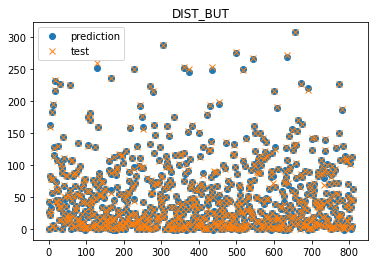

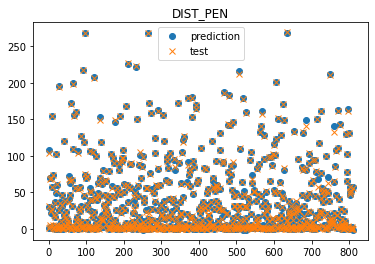

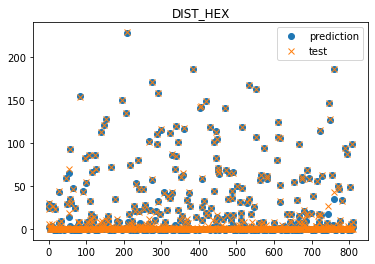

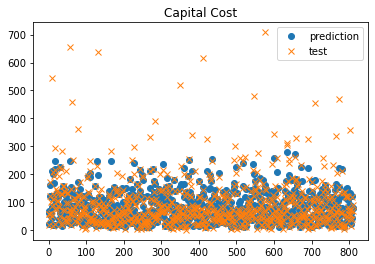

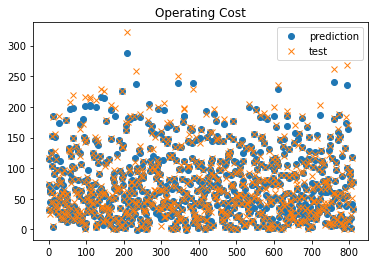

In [211]:
#visualizing how close the predictions are to the test
outputs = ['DIST_BUT','DIST_PEN','DIST_HEX',"Capital Cost",'Operating Cost']
x = np.linspace(0,len(pred),len(pred))
for i in range(0,len(outputs)):
    plt.plot(x,pred[:,i],'o', label='prediction')
    plt.plot(x,test[:,i],'x', label='test')
    plt.legend()
    plt.title(outputs[i])
    plt.show()